In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [17]:
df_data = pd.read_csv('data/data1.csv')
features = ['p00','p01','p02','p03','p04','p05','p06','p07','p08','p09','p10','p11','p12','p13','p14','p15','p16','p17','p18','p19','p20','s1','s2']
X = df_data[features]
y = df_data['multi']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

In [19]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

In [20]:
y_test

11267    0
11969    0
13610    2
13425    2
14398    0
        ..
13823    0
1047     0
2111     1
13362    0
12529    0
Name: multi, Length: 3228, dtype: int64

In [21]:
y_test_bin

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [22]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [23]:
y_score

array([[9.85051400e-01, 1.49483986e-02, 2.01639534e-07],
       [9.93581396e-01, 6.41850418e-03, 9.93581495e-08],
       [1.55791432e-03, 2.77145553e-01, 7.21296533e-01],
       ...,
       [6.56649868e-01, 2.57079048e-01, 8.62710845e-02],
       [8.94143186e-01, 1.03563877e-01, 2.29293730e-03],
       [9.49750428e-01, 5.01758244e-02, 7.37478445e-05]])

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [25]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

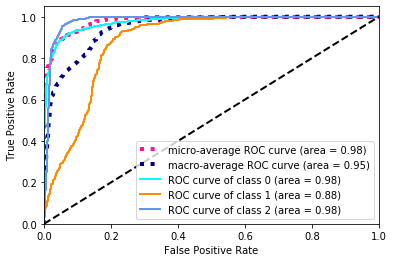

In [26]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [27]:
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_bin, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_bin, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.947070 (macro),
0.967633 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.947070 (macro),
0.967633 (weighted by prevalence)


In [28]:
#Поскольку y_score - массив вероятностей классов, причем возможна такая ситуация, когда для некоторого набора параметров класс
#не будет предсказан вовсе (например если вероятности будут [0.2 0.35 0.45], .predict класс не определит), 
#будем считать, что класс определяется по позиции максимального значения вероятности в строке.
y_score_1 = np.argmax(y_score, axis = 1)
print(y_score_1)
y_score_1.shape

[0 0 2 ... 0 0 0]


(3228,)

In [29]:
confusion = confusion_matrix(y_test, y_score_1)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[2567    8   20]
 [ 189   20  101]
 [  24    5  294]]


In [30]:
print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_score_1, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_score_1, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_score_1, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_score_1, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_score_1, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_score_1, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_score_1, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_score_1, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_score_1, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, y_score_1, target_names=['Class 0', 'Class 1', 'Class 2']))

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.75
Macro Recall: 0.65
Macro F1-score: 0.62

Weighted Precision: 0.87
Weighted Recall: 0.89
Weighted F1-score: 0.86

Classification Report

              precision    recall  f1-score   support

     Class 0       0.92      0.99      0.96      2595
     Class 1       0.61      0.06      0.12       310
     Class 2       0.71      0.91      0.80       323

    accuracy                           0.89      3228
   macro avg       0.75      0.65      0.62      3228
weighted avg       0.87      0.89      0.86      3228



Для Class 0 и Class 2 классификатор сработал достаточно хорошо, Class 1 судя по Confusion Matrix определяется довольно плохо. 
Это может быть связано с ручным выбором параметров классификатора, произвольном задании "порога" классов при анализе и малым объемом класса 1.